In [42]:
import numpy as np
import torch
import torchvision
import torchgeo
import os
import random
import rasterio
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader
from torchgeo.datasets import LandCoverAI
from PIL import ImageFile
import torchvision.transforms.functional as F

from landcoversiamese import *
from train_siamese import *
from distance_compare import *

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [20]:
DATA_FOLDER = 'landcover.ai.v1'
MARGIN = 1

data = LandcoverAITriplet(DATA_FOLDER)
dataloader = DataLoader(data, batch_size=32, shuffle=True)
model = LandSiamese()
criterion = torch.nn.TripletMarginLoss(margin=MARGIN)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


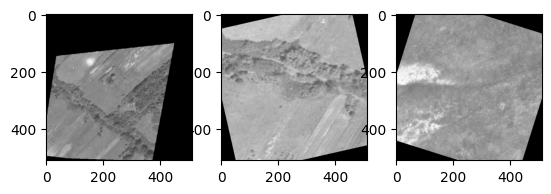

In [50]:
def transforms(anchor, pos, neg):
    T = torch.nn.Sequential(torchvision.transforms.RandomPerspective(distortion_scale=0.4),
                    torchvision.transforms.RandomResizedCrop((512, 512), scale=(0.01, 1.0)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.RandomRotation((-50, 50)))
    anchor = T(anchor)
    pos = T(pos)
    neg = T(neg)
    return anchor, pos, neg

def transforms(anchor, pos, neg):
    T = torch.nn.Sequential(torchvision.transforms.RandomPerspective(distortion_scale=0.6),
                    torchvision.transforms.RandomResizedCrop((512, 512), scale=(0.01, 1.0)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.RandomRotation((-50, 50)),
                    torchvision.transforms.RandomAutocontrast(p=0.25),
                    torchvision.transforms.RandomEqualize(p=0.25),
                    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.2),
                    )
    anchor = T(anchor)
    pos = T(pos)
    neg = T(neg)
    return anchor, pos, neg

data = LandcoverAITriplet(DATA_FOLDER, transform=transforms, anchor_type='image')
dataloader = DataLoader(data, batch_size=1, shuffle=True)
for anchor, pos, neg in dataloader:
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(anchor[0, 0], cmap='gray')
    axs[1].imshow(pos[0, 0], cmap='gray')
    axs[2].imshow(neg[0, 0], cmap='gray')
    break
plt.show()

dataloader = DataLoader(data, batch_size=32, shuffle=True)

In [22]:
# train_triplet(model, dataloader, criterion, device, num_epochs=100, lr=1e-4, margin=1, save_path='models')

In [23]:
model.load_state_dict(torch.load('models/landcoversiamese_augmented100_0.4630853235721588.pt'))
model.to(device)

LandSiamese(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64,

In [24]:
class ProcessImagesSiamese(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()

    def __call__(self, patch_img, patch):
        patch_img = F.resize(patch_img, [512, 512])
        patch = F.resize(patch.unsqueeze(0), [512, 512])
        patch_img = self.model.forward_one(patch_img.unsqueeze(0).to(device)).squeeze().to('cpu')
        patch = self.model.forward_one(patch.unsqueeze(0).to(device)).squeeze().to('cpu')
        return patch_img, patch


In [25]:
# IMG_DIR = 'landcover.ai.v1/images'
# MAP_DIR = 'landcover.ai.v1/masks'

# # get full sat image
# file = random.choice(os.listdir(IMG_DIR))
# full_image = cv2.imread(os.path.join(IMG_DIR, file))
# full_image = cv2.resize(full_image, (2560, 2560))
# full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2GRAY)
# full_img = full_image
# full_image = F.to_tensor(full_image).unsqueeze(0)

# # get full seg image / map
# map_image = cv2.imread(os.path.join(MAP_DIR, file))
# map_image = cv2.resize(map_image, (2560, 2560))
# map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)

# # get a random patch from the image
# patch_size = 256
# stride_size = 128
# patches = full_image.unfold(2, patch_size, stride_size).unfold(3, patch_size, stride_size)
# num_images_x = patches.shape[-3]
# num_images_y = patches.shape[-4]
# x = random.randint(0, num_images_x-1)
# y = random.randint(0, num_images_y-1)
# patch_img = patches[0, 0, y, x].numpy()
# patch_img = np.swapaxes(patch_img, 1, 0)
# print(x, y)


# process_images = ProcessImagesSiamese(model)
# predx, predy, distances, patches = find_closest_dist(full_img, patch_img, patch_size=256, stride_size=128, process=process_images, return_patches=True)
# print(predx, predy)

In [26]:
# process_images = ProcessImagesSiamese(model)
# predx, predy, distances, patches = find_closest_dist(full_image.squeeze().numpy(), patch_img, patch_size=256, stride_size=128, process=None, return_patches=True)
# print(predx, predy)
# plt.imshow(patch_img)
# plt.show()
# plt.imshow(patches[0, 0, predy, predx])
# plt.show()

(1080, 1920)
(2560, 5632)

8 10


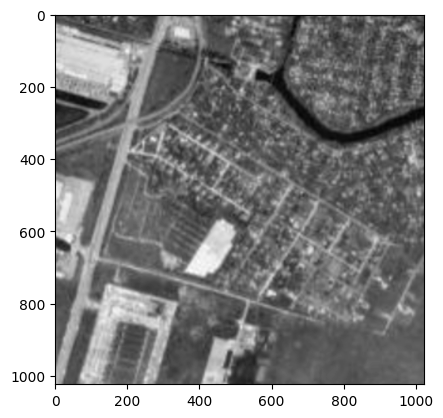

In [27]:
# get full sat image
full_image = cv2.imread('map.png')
full_image = cv2.resize(full_image, (5632, 2560))
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2GRAY)
full_img = full_image
full_image = F.to_tensor(full_image).unsqueeze(0)

# get patch 
patch_img = cv2.imread('extracted.jpg')
patch_img = cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY)
h, w = patch_img.shape
patch_img1 = patch_img[:, :h]
patch_img2 = patch_img[:, (w-h):]
k = int(((w-h)/2))
patch_img3 = patch_img[:, k:(k+h)]
patch_img1 = cv2.resize(patch_img1, (512, 512))
patch_img2 = cv2.resize(patch_img2, (512, 512))
patch_img3 = cv2.resize(patch_img3, (512, 512))

patch_imgs = [patch_img1, patch_img2, patch_img3]

print(patch_img.shape)
print(full_img.shape)

process_images = ProcessImagesSiamese(model)
predx, predy, distances, patches = find_closest_dist(full_img, patch_imgs, patch_size=1024, stride_size=128, process=process_images, return_patches=True)
print()
print(predx, predy)
plt.imshow(patches[0, 0, predx, predy], cmap='gray')
plt.show()

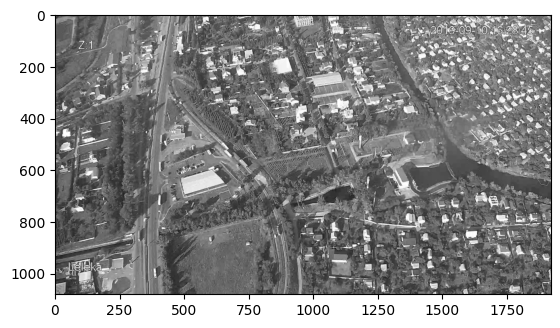

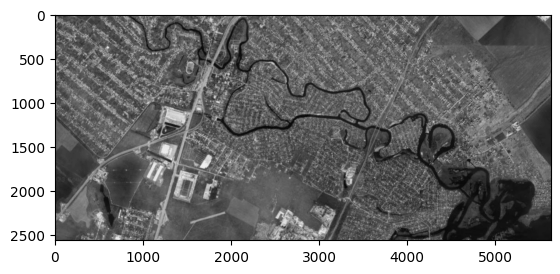

In [28]:
patch_img = cv2.imread('extracted.jpg')
patch_img = cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY)
# cut into two and pool preds?
plt.imshow(patch_img, cmap='gray')
plt.show()

plt.imshow(full_img, cmap='gray')
plt.show()

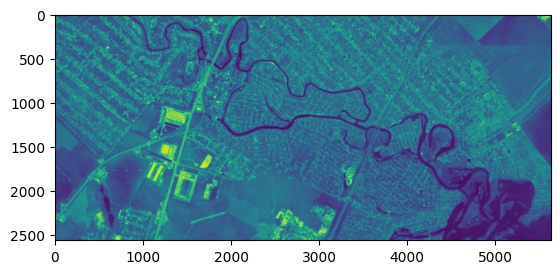

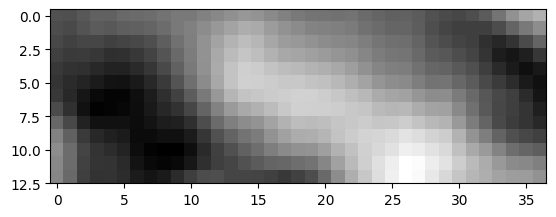

In [29]:
plt.imshow(full_img)
plt.show()
plt.imshow(distances, cmap='gray')
plt.show()

In [30]:

# get full sat image
full_image = cv2.imread('tiled_map_720.png')
full_image = cv2.resize(full_image, (5632, 2560))
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2GRAY)
full_img = full_image
full_image = F.to_tensor(full_image).unsqueeze(0)

# get patch 
patch_img = cv2.imread('extracted.jpg')
patch_img = cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY)
h, w = patch_img.shape
patch_img1 = patch_img[:h, :h]
patch_img2 = patch_img[:, (w-h):]
patch_img1 = cv2.resize(patch_img1, (512, 512))
patch_img2 = cv2.resize(patch_img2, (512, 512))

print(patch_img.shape)
print(full_img.shape)

process_images = ProcessImagesSiamese(model)
predx, predy, distances, patches = find_closest_dist(full_img, [patch_img1, patch_img2], patch_size=1024, stride_size=128, process=process_images, return_patches=True)
print()
print(predx, predy)
print('....')

(1080, 1920)
(2560, 5632)

7 12
....


In [33]:
map = rasterio.open('google-35_107470-48_571642.tiff')
map.count, map.bounds

(3,
 BoundingBox(left=35.079345703125, bottom=48.54570549184744, right=35.13427734375, top=48.60022506046891))

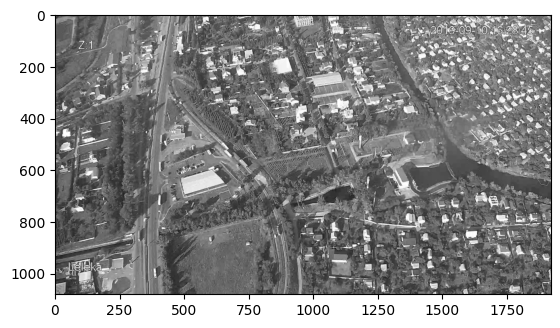

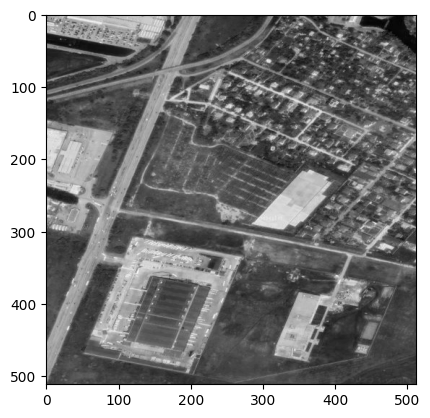

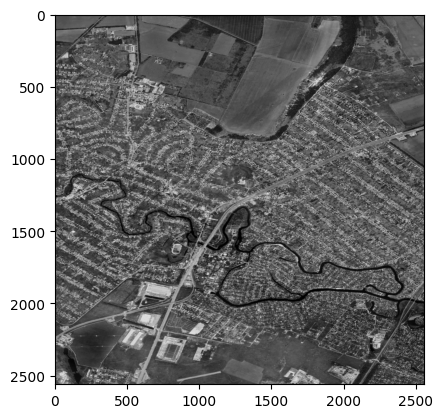

In [83]:
map_img = np.stack([map.read(1), map.read(1), map.read(1)], axis=2)
map_img = map_img/map_img.max()
map_img = cv2.resize(map_img, (2560, 2560))
map_img = cv2.cvtColor(map_img.astype(np.float32), cv2.COLOR_BGR2GRAY)

patch_size=512
stride_size=128
predx, predy, distances1, patches = find_closest_dist(map_img.astype(np.float32), [patch_img1, patch_img2], patch_size=patch_size, stride_size=stride_size, process=process_images, return_patches=True)
patch_img = cv2.imread('extracted.jpg')
patch_img = cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY)
# cut into two and pool preds?
plt.imshow(patch_img, cmap='gray')
plt.show()

plt.imshow(patches[0, 0, predy, predx], cmap='gray')
plt.show()

plt.imshow(map_img, cmap='gray')
plt.show()

In [97]:
xmap = int(predx*stride_size+(0.5*patch_size))
ymap = int(predy*stride_size+(0.5*patch_size))
x, y = map.xy(ymap, xmap)
x, y, 35.09858250617981, 48.56932353934791

(35.09858250617981, 48.56932353934791, 35.09858250617981, 48.56932353934791)

In [85]:
predx, predy, xmap, ymap

(5, 15, 896, 2176)

In [86]:
7*stride_size+(0.5*patch_size)

1152.0

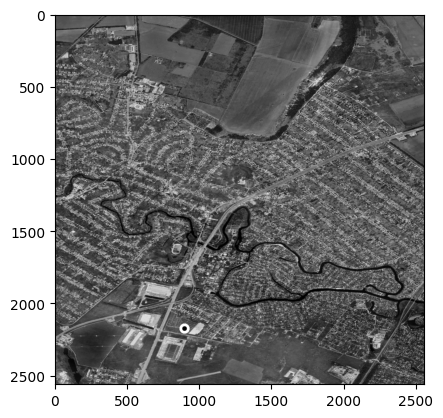

In [95]:
image = cv2.circle(map_img, (xmap, ymap), radius=10, color=(1, 0, 0), thickness=50)
image = cv2.circle(map_img, (xmap, ymap), radius=1, color=(0, 0, 0), thickness=30)
plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
map.xy(xmap, ymap)

(35.12604832649231, 48.587496728888404)

In [ ]:
map.xy(0, 0)

(35.07935643196106, 48.60021796156674)

In [ ]:
map.xy(map.height // 2, map.width // 2)


(35.10682225227356, 48.57295817725601)

In [ ]:
map.bounds


BoundingBox(left=35.079345703125, bottom=48.54570549184744, right=35.13427734375, top=48.60022506046891)

In [ ]:
map.height, ymap

(3840, 2176.0)

(1080, 1920)
(2560, 5632)

2 13


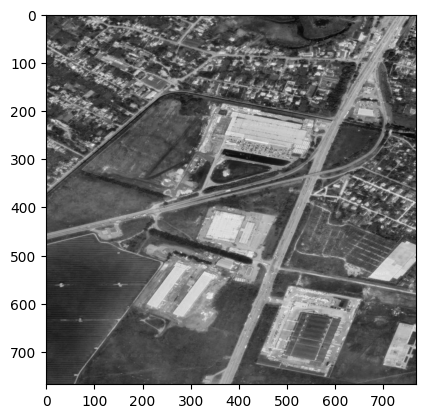

....


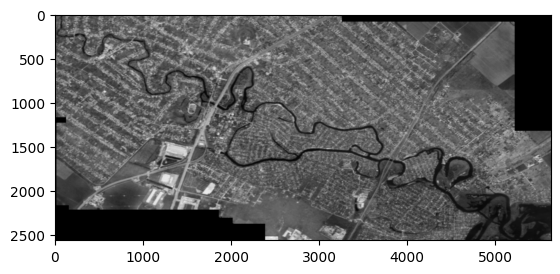

In [41]:
map_img = np.stack([map.read(1), map.read(1), map.read(1)], axis=2)
map_img = map_img/map_img.max()
map_img = cv2.resize(map_img, (2560, 2560))
map_img = map_img.astype(np.float32)

# get patch 
patch_img = cv2.imread('extracted.jpg')
patch_img = cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY)
h, w = patch_img.shape
patch_img1 = patch_img[:, :h]
patch_img2 = patch_img[:, (w-h):]
k = int(((w-h)/2))
patch_img3 = patch_img[:, k:(k+h)]
patch_img1 = cv2.resize(patch_img1, (512, 512))
patch_img2 = cv2.resize(patch_img2, (512, 512))
patch_img3 = cv2.resize(patch_img3, (512, 512))

print(patch_img.shape)
print(full_img.shape)

patch_size = 768
stride_size = 128

process_images = ProcessImagesSiamese(model)
predx, predy, distances, patches = find_closest_dist(map_img, [patch_img1, patch_img2, patch_img3], patch_size=patch_size, stride_size=stride_size, process=process_images, return_patches=True)
print()
print(predx, predy)
plt.imshow(patches[0, 0, predy, predx], cmap='gray')
plt.show()
print('....')

plt.imshow(full_img, cmap='gray')
plt.show()

In [ ]:
distances.shape[-2:]

torch.Size([13, 37])

In [3]:
256/2

128.0